In [1]:
%matplotlib inline

In [2]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from sklearn.neighbors import KDTree
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

In [3]:
import pickle
from Utils import plot_confusion_matrix, annotate_confusion, feature_extraction, smooth_result

In [4]:
import matplotlib as mpl
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

In [5]:
mpl.style.use('default')
mpl.rcParams["figure.dpi"] = 600
mpl.rcParams["font.size"] = 7
mpl.rcParams["font.family"] = 'sans-serif'
mpl.rcParams["font.sans-serif"] = 'Arial'
mpl.rcParams["mathtext.fontset"] = 'cm'
mpl.rcParams['text.usetex'] = False
mpl.rcParams["figure.figsize"] = [3.5, 3.5]

#### Read LiDAR data with fpfh and get the feature fpfh, normal, relative height for training and testing

In [6]:
train_data = np.loadtxt('./data/Vaihingen3D_Traininig_fpfh_5_ground.txt', skiprows=11)
train_data_feature = feature_extraction(train_data)
train_data_class = train_data[:, 34]

test_data = np.loadtxt('./data/Vaihingen3D_EVAL_WITH_REF_fpfh_5_ground.txt', skiprows=11)
test_data_feature = feature_extraction(test_data)
test_data_class = test_data[:, 34]

class_name =  ['PL', 'LV', 'IS', 'Car', 'Fence', 'Roof', 'Facade', 'Shrub', 'Tree']

#### Parameter tuning

In [7]:
# parameters = {'min_samples_leaf':np.arange(10, 100, 10)}
# dt = DecisionTreeClassifier(random_state=0)
# gsearch1 = GridSearchCV(dt, parameters, cv=5)
# gsearch1.fit(train_data_feature, train_data_class)
# joblib.dump(gsearch1, './result/classifier/GridSearchCV1_DT_MSL_without_intensity.joblib')
gsearch1 = joblib.load('./result/classifier/GridSearchCV1_DT_MSL_without_intensity.joblib')

In [8]:
# parameters = {'min_samples_leaf':np.arange(2, 10, 2)}
# dt = DecisionTreeClassifier(random_state=0)
# gsearch2 = GridSearchCV(dt, parameters, cv=5)
# gsearch2.fit(train_data_feature, train_data_class)
# joblib.dump(gsearch2, './result/classifier/GridSearchCV2_DT_MSL_without_intensity.joblib')
gsearch2 = joblib.load('./result/classifier/GridSearchCV2_DT_MSL_without_intensity.joblib')

In [9]:
gsearch2.best_params_

{'min_samples_leaf': 4}

#### Decision Tree without intensity ($min\_samples\_leaf = 4$)

In [10]:
# clf_DT_without_i = DecisionTreeClassifier(random_state=0, min_samples_leaf=4)
# clf_DT_without_i.fit(train_data_feature, train_data_class)
# joblib.dump(clf_DT_without_i, './result/classifier/DT_without_intensity.joblib')
clf_DT_without_i = joblib.load('./result/classifier/DT_without_intensity.joblib')

In [11]:
DT_without_i = clf_DT_without_i.predict(test_data_feature)

test_xyz = test_data[:, -3:] 
kdt = KDTree(test_xyz, metric = 'euclidean')
ind = kdt.query(test_xyz, k = 6, return_distance=False)
smooth_DT_without_i = smooth_result(DT_without_i, ind)

tmp = np.hstack([test_xyz, smooth_DT_without_i.reshape([-1, 1])])
np.savetxt('./result/classification_result/DT_without_i.pts', tmp, fmt = '%.2f, %.2f, %.2f, %d')

In [12]:
tmp = smooth_DT_without_i == test_data_class
tmp = tmp.astype('int')
tmp = np.hstack([test_xyz, tmp.reshape([-1, 1])])
np.savetxt('./result/classification_result/DT_without_i_error.pts', tmp, fmt = '%.2f, %.2f, %.2f, %d')

In [13]:
precision_recall_fscore_support(test_data_class, smooth_DT_without_i)

(array([0.01134982, 0.56102888, 0.78514752, 0.39403853, 0.18118609,
        0.89426192, 0.23385238, 0.32063039, 0.68734531]),
 array([0.04666667, 0.69749721, 0.59961171, 0.29234088, 0.11937483,
        0.75431003, 0.37063435, 0.38036909, 0.7835909 ]),
 array([0.01825888, 0.62186407, 0.67995019, 0.33565567, 0.14392463,
        0.81834552, 0.286768  , 0.34795429, 0.73231936]),
 array([   600,  98690, 101986,   3708,   7422, 109048,  11224,  24818,
         54226], dtype=int64))

In [14]:
precision_recall_fscore_support(test_data_class, smooth_DT_without_i, average='weighted')

(0.6888781484197873, 0.6565910978767227, 0.6651207513901127, None)

#### GMM for intensity of impervious surface and low vegetation classified by DT without intensity

In [15]:
from sklearn import mixture

In [16]:
# smooth the intensity of LiDAR
test_i = test_data[:, -7]
neigh_i = test_i[ind]
smooth_test_i = np.average(neigh_i, axis=1)

In [17]:
# Gaussian mixture model for the intensity of low vegetation and impervious surface.
DT_lv_im_i = smooth_test_i[np.logical_or(DT_without_i == 1, DT_without_i == 2)]
DT_lv_im_i = DT_lv_im_i.reshape((-1, 1))
GMM = mixture.GaussianMixture(n_components=2, random_state=0)
GMM.fit(DT_lv_im_i)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

#### Joint the classification of RF without intensity and GMM

In [18]:
proba_DT = clf_DT_without_i.predict_proba(test_data_feature)
proba_DT_lv_im = proba_DT[np.logical_or(DT_without_i == 1, DT_without_i == 2), 1:3]
ratio_proba_DT_lv_im = np.zeros(proba_DT_lv_im.shape[0])

proba_DT_lv_larger_im = proba_DT_lv_im[:, 0] > proba_DT_lv_im[:, 1]
ratio_proba_DT_lv_im[proba_DT_lv_larger_im] = np.divide(proba_DT_lv_im[proba_DT_lv_larger_im, 0],
                                                        proba_DT_lv_im[proba_DT_lv_larger_im, 1])

proba_DT_lv_smaller_im = np.logical_not(proba_DT_lv_larger_im)
ratio_proba_DT_lv_im[proba_DT_lv_smaller_im] = np.divide(proba_DT_lv_im[proba_DT_lv_smaller_im, 1],
                                                         proba_DT_lv_im[proba_DT_lv_smaller_im,0])

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [19]:
# calculate the ratio of larger and smaller for GMM

proba_GMM_lv_im = GMM.predict_proba(DT_lv_im_i)
ratio_proba_GMM_lv_im = np.zeros(proba_GMM_lv_im.shape[0])

proba_GMM_lv_larger_im = proba_GMM_lv_im[:, 1] > proba_GMM_lv_im[:, 0]
ratio_proba_GMM_lv_im[proba_GMM_lv_larger_im] = np.divide(proba_GMM_lv_im[proba_GMM_lv_larger_im, 1],
                                                    proba_GMM_lv_im[proba_GMM_lv_larger_im, 0])

proba_GMM_lv_smaller_im = np.logical_not(proba_GMM_lv_larger_im)
ratio_proba_GMM_lv_im[proba_GMM_lv_smaller_im] = np.divide(proba_GMM_lv_im[proba_GMM_lv_smaller_im, 0],
                                                     proba_GMM_lv_im[proba_GMM_lv_smaller_im, 1])

In [20]:
# the result for ground level points
DT_lv_im = DT_without_i[np.logical_or(DT_without_i==1, DT_without_i==2)]
GMM_lv_im = GMM.predict(DT_lv_im_i)

# set the semantic label for GMM clusters 
GMM_lv_im[GMM_lv_im==0] = 2

In [21]:
# calculate the effect of joint coefficient on the performance of the joint classification
effect_a = {'f1_lv': [],
            'f1_im': [],
            'Acc': []}
tmp = list(1/np.arange(2, 21, 1))
tmp.reverse()
list_a = tmp + list(np.arange(1, 21, 1))
for a in list_a:
    judge = a * ratio_proba_DT_lv_im >= ratio_proba_GMM_lv_im   # compare the probability of RF and GMM, the result is determined by larger
    refine_lv_im = np.zeros(judge.shape)
    refine_lv_im[judge] = DT_lv_im[judge]
    refine_lv_im[np.logical_not(judge)] = GMM_lv_im[np.logical_not(judge)]
    
    joint_result = np.copy(DT_without_i)
    joint_result[np.logical_or(joint_result==1, joint_result==2)] = refine_lv_im
    smooth_joint_result = smooth_result(joint_result, ind)
    effect_a['Acc'].append(precision_recall_fscore_support(test_data_class, joint_result, average='weighted')[2])
    
    tmp = precision_recall_fscore_support(test_data_class, smooth_joint_result)
    effect_a['f1_lv'].append(tmp[2][1])
    effect_a['f1_im'].append(tmp[2][2])

with open("./result/classifier/DT_effect_a.pkl","wb") as f:
    pickle.dump(effect_a,f)
    
with open("./result/classifier/DT_effect_a.pkl","rb") as f:
    effect_a = pickle.load(f)    

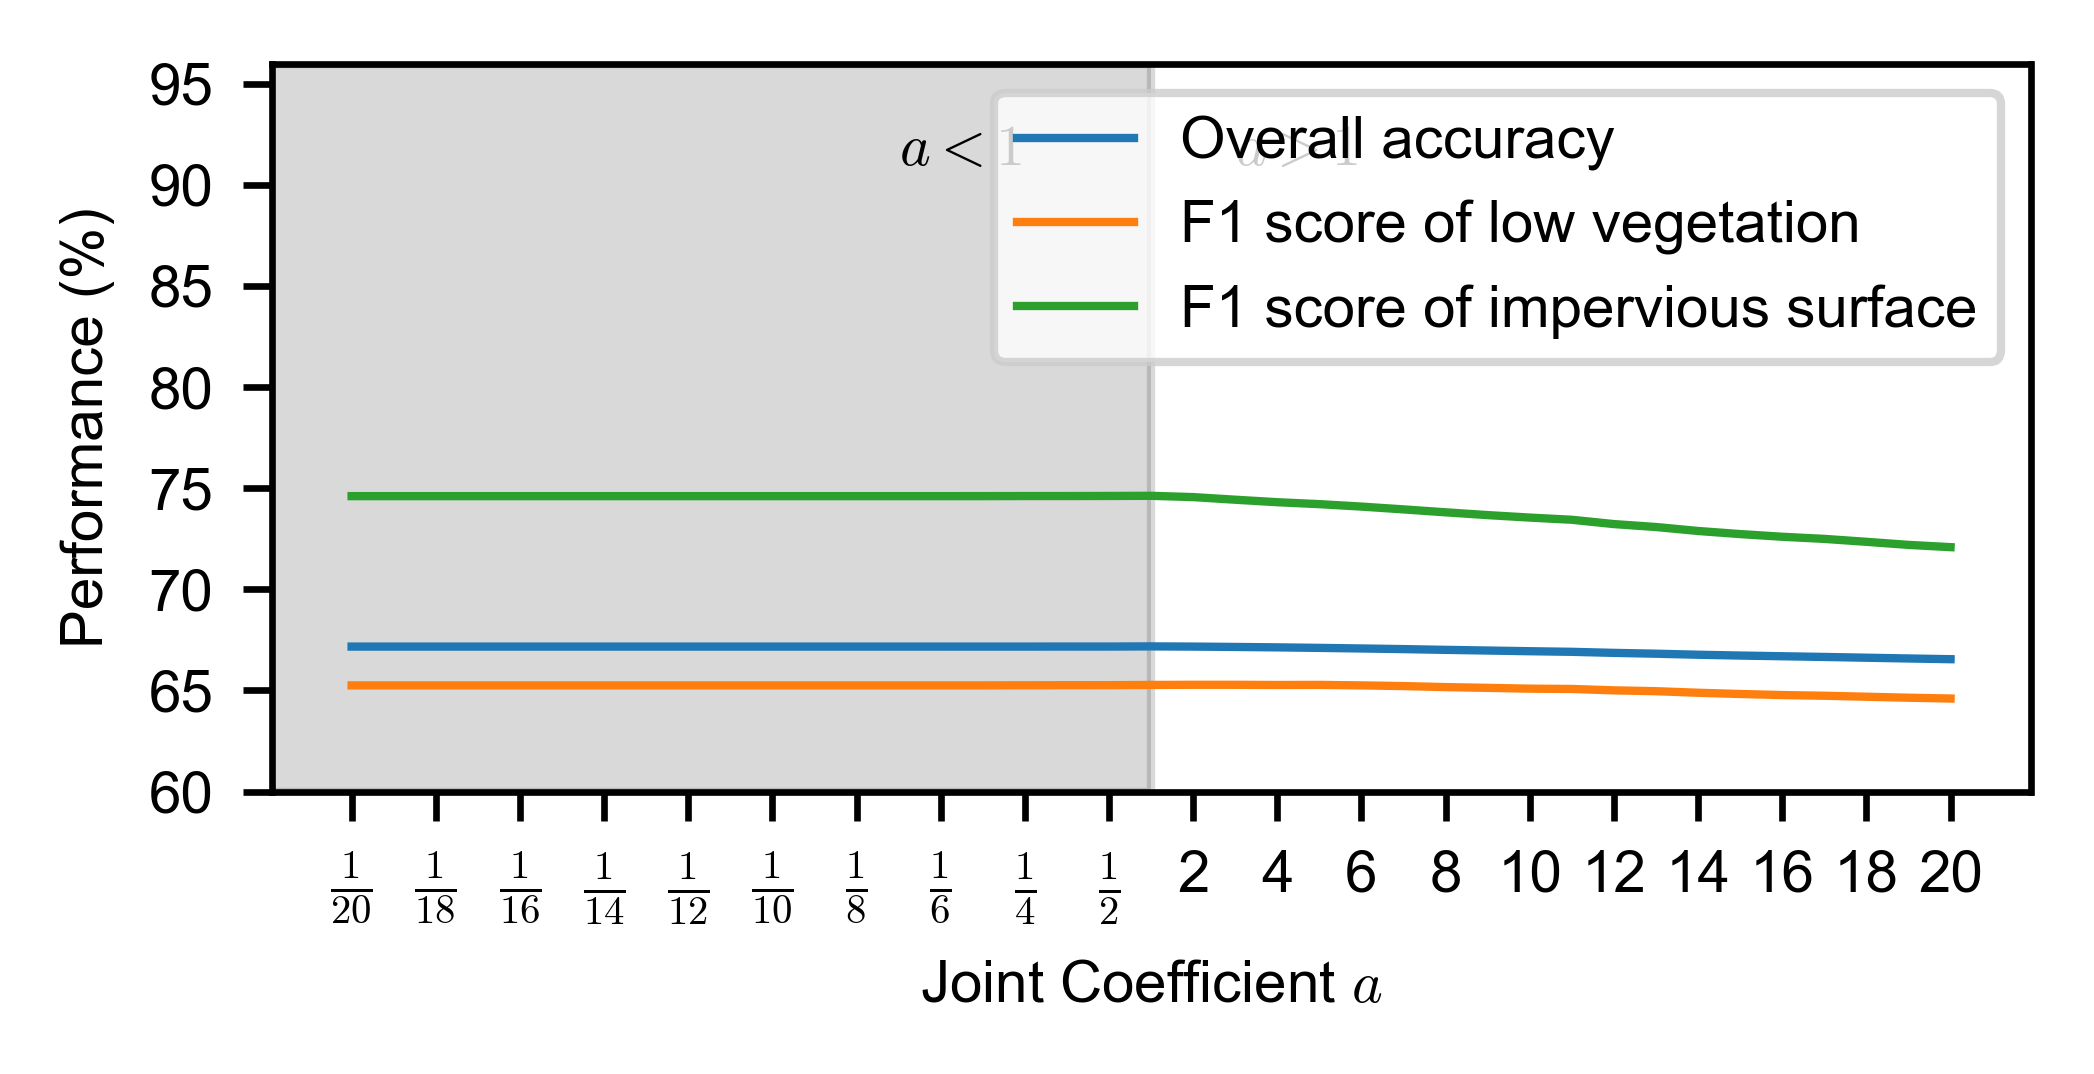

In [22]:
fig, ax = plt.subplots(figsize=(3.5, 1.8))
x = x_ticks = np.arange(1, 40, 1)
ax.plot(x, effect_a['Acc'], label='Overall accuracy', lw=1)
ax.plot(x, effect_a['f1_lv'], label='F1 score of low vegetation', lw=1)
ax.plot(x, effect_a['f1_im'], label='F1 score of impervious surface', lw=1)
x_ticks = np.arange(1, 40, 2)
ax.set_xticks(x_ticks)

x_label = []
for i in range(2, 21, 2):
    x_label.append(r"$\frac{{{}}}{{{}}}$".format(1, i))
x_label.reverse()
for i in range(2, 21, 2):
    x_label.append(i)
ax.set_xticklabels(x_label)
ax.set_xlabel('Joint Coefficient $a$')


ax.set_ylim([0.6, 0.96])
ax.set_yticks(np.arange(0.6, 0.96, 0.05))
ax.set_yticklabels((np.arange(0.6, 0.96, 0.05)*100).astype('int'))
ax.set_ylabel('Performance (%)')

ax.legend(ncol=1)
ax.add_patch(Rectangle((-1, 0.6), 21, 0.36, color='black', alpha=0.15))
ax.text(14, 0.91, '$a<1$')
ax.text(22, 0.91, '$a>1$')

plt.tight_layout()
plt.savefig("./result/figure/DT_effect_a.png")

In [23]:
a = 1                                                       # a is hyper-parameter, which determine the ratio of GMM and RF, from analysis above, we set a=8
judge = a * ratio_proba_DT_lv_im >= ratio_proba_GMM_lv_im   # compare the probability of RF and GMM, the result is determined by larger
refine_lv_im = np.zeros(judge.shape)
refine_lv_im[judge] = DT_lv_im[judge]
refine_lv_im[np.logical_not(judge)] = GMM_lv_im[np.logical_not(judge)]

joint_result = np.copy(DT_without_i)
joint_result[np.logical_or(joint_result==1, joint_result==2)] = refine_lv_im

In [24]:
smooth_joint_result = smooth_result(joint_result, ind)
tmp = np.hstack([test_xyz, smooth_joint_result.reshape([-1, 1])])
np.savetxt('./result/classification_result/DT_joint_result.pts', tmp, fmt = '%.2f, %.2f, %.2f, %d')

tmp = smooth_joint_result == test_data_class
tmp = tmp.astype('int')
tmp = np.hstack([test_xyz, tmp.reshape([-1, 1])])
np.savetxt('./result/classification_result/DT_joint_result_i_error.pts', tmp, fmt = '%.2f, %.2f, %.2f, %d')

In [25]:
precision_recall_fscore_support(test_data_class, smooth_joint_result, average='weighted')

(0.7072054399813229, 0.6803158441861256, 0.6888960647368727, None)

In [26]:
precision_recall_fscore_support(test_data_class, smooth_joint_result)

(array([0.01134522, 0.60835683, 0.81337499, 0.39138372, 0.18170657,
        0.89431743, 0.2338356 , 0.3204557 , 0.68735643]),
 array([0.04666667, 0.70400243, 0.6893103 , 0.28910464, 0.1196443 ,
        0.75436505, 0.37054526, 0.3796841 , 0.7835909 ]),
 array([0.01825293, 0.65269427, 0.74622113, 0.33255778, 0.14428467,
        0.81840114, 0.28672871, 0.34756469, 0.73232567]),
 array([   600,  98690, 101986,   3708,   7422, 109048,  11224,  24818,
         54226], dtype=int64))

#### DT with intensity

In [27]:
# smooth intensity
train_xyz = train_data[:, -3:]
intensity = train_data[:, -7]
kdt = KDTree(train_xyz, metric = 'euclidean')
ind = kdt.query(train_xyz, k = 6, return_distance=False)
neigh_intensity = intensity[ind]
smooth_intensity = np.average(neigh_intensity, axis=1)
smooth_intensity = smooth_intensity.reshape((-1, 1))

# concatenate intensity with other feature
train_data_feature_i = np.hstack((train_data_feature, smooth_intensity))

In [28]:
# same operation with training data
test_xyz = test_data[:, -3:]
intensity = test_data[:, -7]
kdt = KDTree(test_xyz, metric = 'euclidean')
ind = kdt.query(test_xyz, k = 6, return_distance=False)
neigh_intensity = intensity[ind]
smooth_intensity = np.average(neigh_intensity, axis=1)
smooth_intensity = smooth_intensity.reshape((-1, 1))

test_data_feature_i = np.hstack((test_data_feature, smooth_intensity))

In [29]:
# clf_DT_i = DecisionTreeClassifier(random_state=0, min_samples_leaf=4)
# clf_DT_i.fit(train_data_feature_i, train_data_class)
# joblib.dump(clf_DT_i, './result/classifier/DT_with_intensity.joblib')
clf_DT_i = joblib.load('./result/classifier/DT_with_intensity.joblib')

In [30]:
DT_with_i = clf_DT_i.predict(test_data_feature_i)
smooth_DT_with_i = smooth_result(DT_with_i, ind)
tmp = np.hstack([test_xyz, smooth_DT_with_i.reshape([-1, 1])])
np.savetxt('./result/classification_result/DT_with_i.pts', tmp, fmt = '%.2f, %.2f, %.2f, %d')

tmp = smooth_DT_with_i == test_data_class
tmp = tmp.astype('int')
tmp = np.hstack([test_xyz, tmp.reshape([-1, 1])])
np.savetxt('./result/classification_result/DT_with_i_error.pts', tmp, fmt = '%.2f, %.2f, %.2f, %d')

In [31]:
precision_recall_fscore_support(test_data_class, smooth_DT_with_i, average='weighted')

(0.7526616432074287, 0.7274520185950715, 0.7365145092508742, None)

In [32]:
precision_recall_fscore_support(test_data_class, smooth_DT_with_i)

(array([0.02446483, 0.70966894, 0.88390879, 0.42682524, 0.19084753,
        0.90578692, 0.22789943, 0.30711758, 0.69589774]),
 array([0.09333333, 0.76609586, 0.81756319, 0.34843581, 0.12530315,
        0.75672181, 0.37553457, 0.37762914, 0.77708111]),
 array([0.03876774, 0.73680364, 0.84944248, 0.38366741, 0.15128101,
        0.82457157, 0.28365692, 0.33874291, 0.73425221]),
 array([   600,  98690, 101986,   3708,   7422, 109048,  11224,  24818,
         54226], dtype=int64))

#### The confusion matrix between DT considering intensity and the proposed method

In [33]:
# the consistence between joint and DT_i result
precision_recall_fscore_support(smooth_DT_with_i, smooth_joint_result, average='weighted')

(0.7570424879245494, 0.7566561903420269, 0.7562464825164605, None)

E:\als_fpfh_brf\Utils.py:70: RuntimeWarning: divide by zero encountered in log
  im = ax.imshow(np.log(confusion_matrix), **kwargs)
E:\als_fpfh_brf\Utils.py:136: RuntimeWarning: divide by zero encountered in log
  threshold = im.norm(np.log(data).max())/2.
E:\als_fpfh_brf\Utils.py:153: RuntimeWarning: divide by zero encountered in log
  kw.update(color=textcolors[im.norm(np.log(data[i, j])) > threshold])


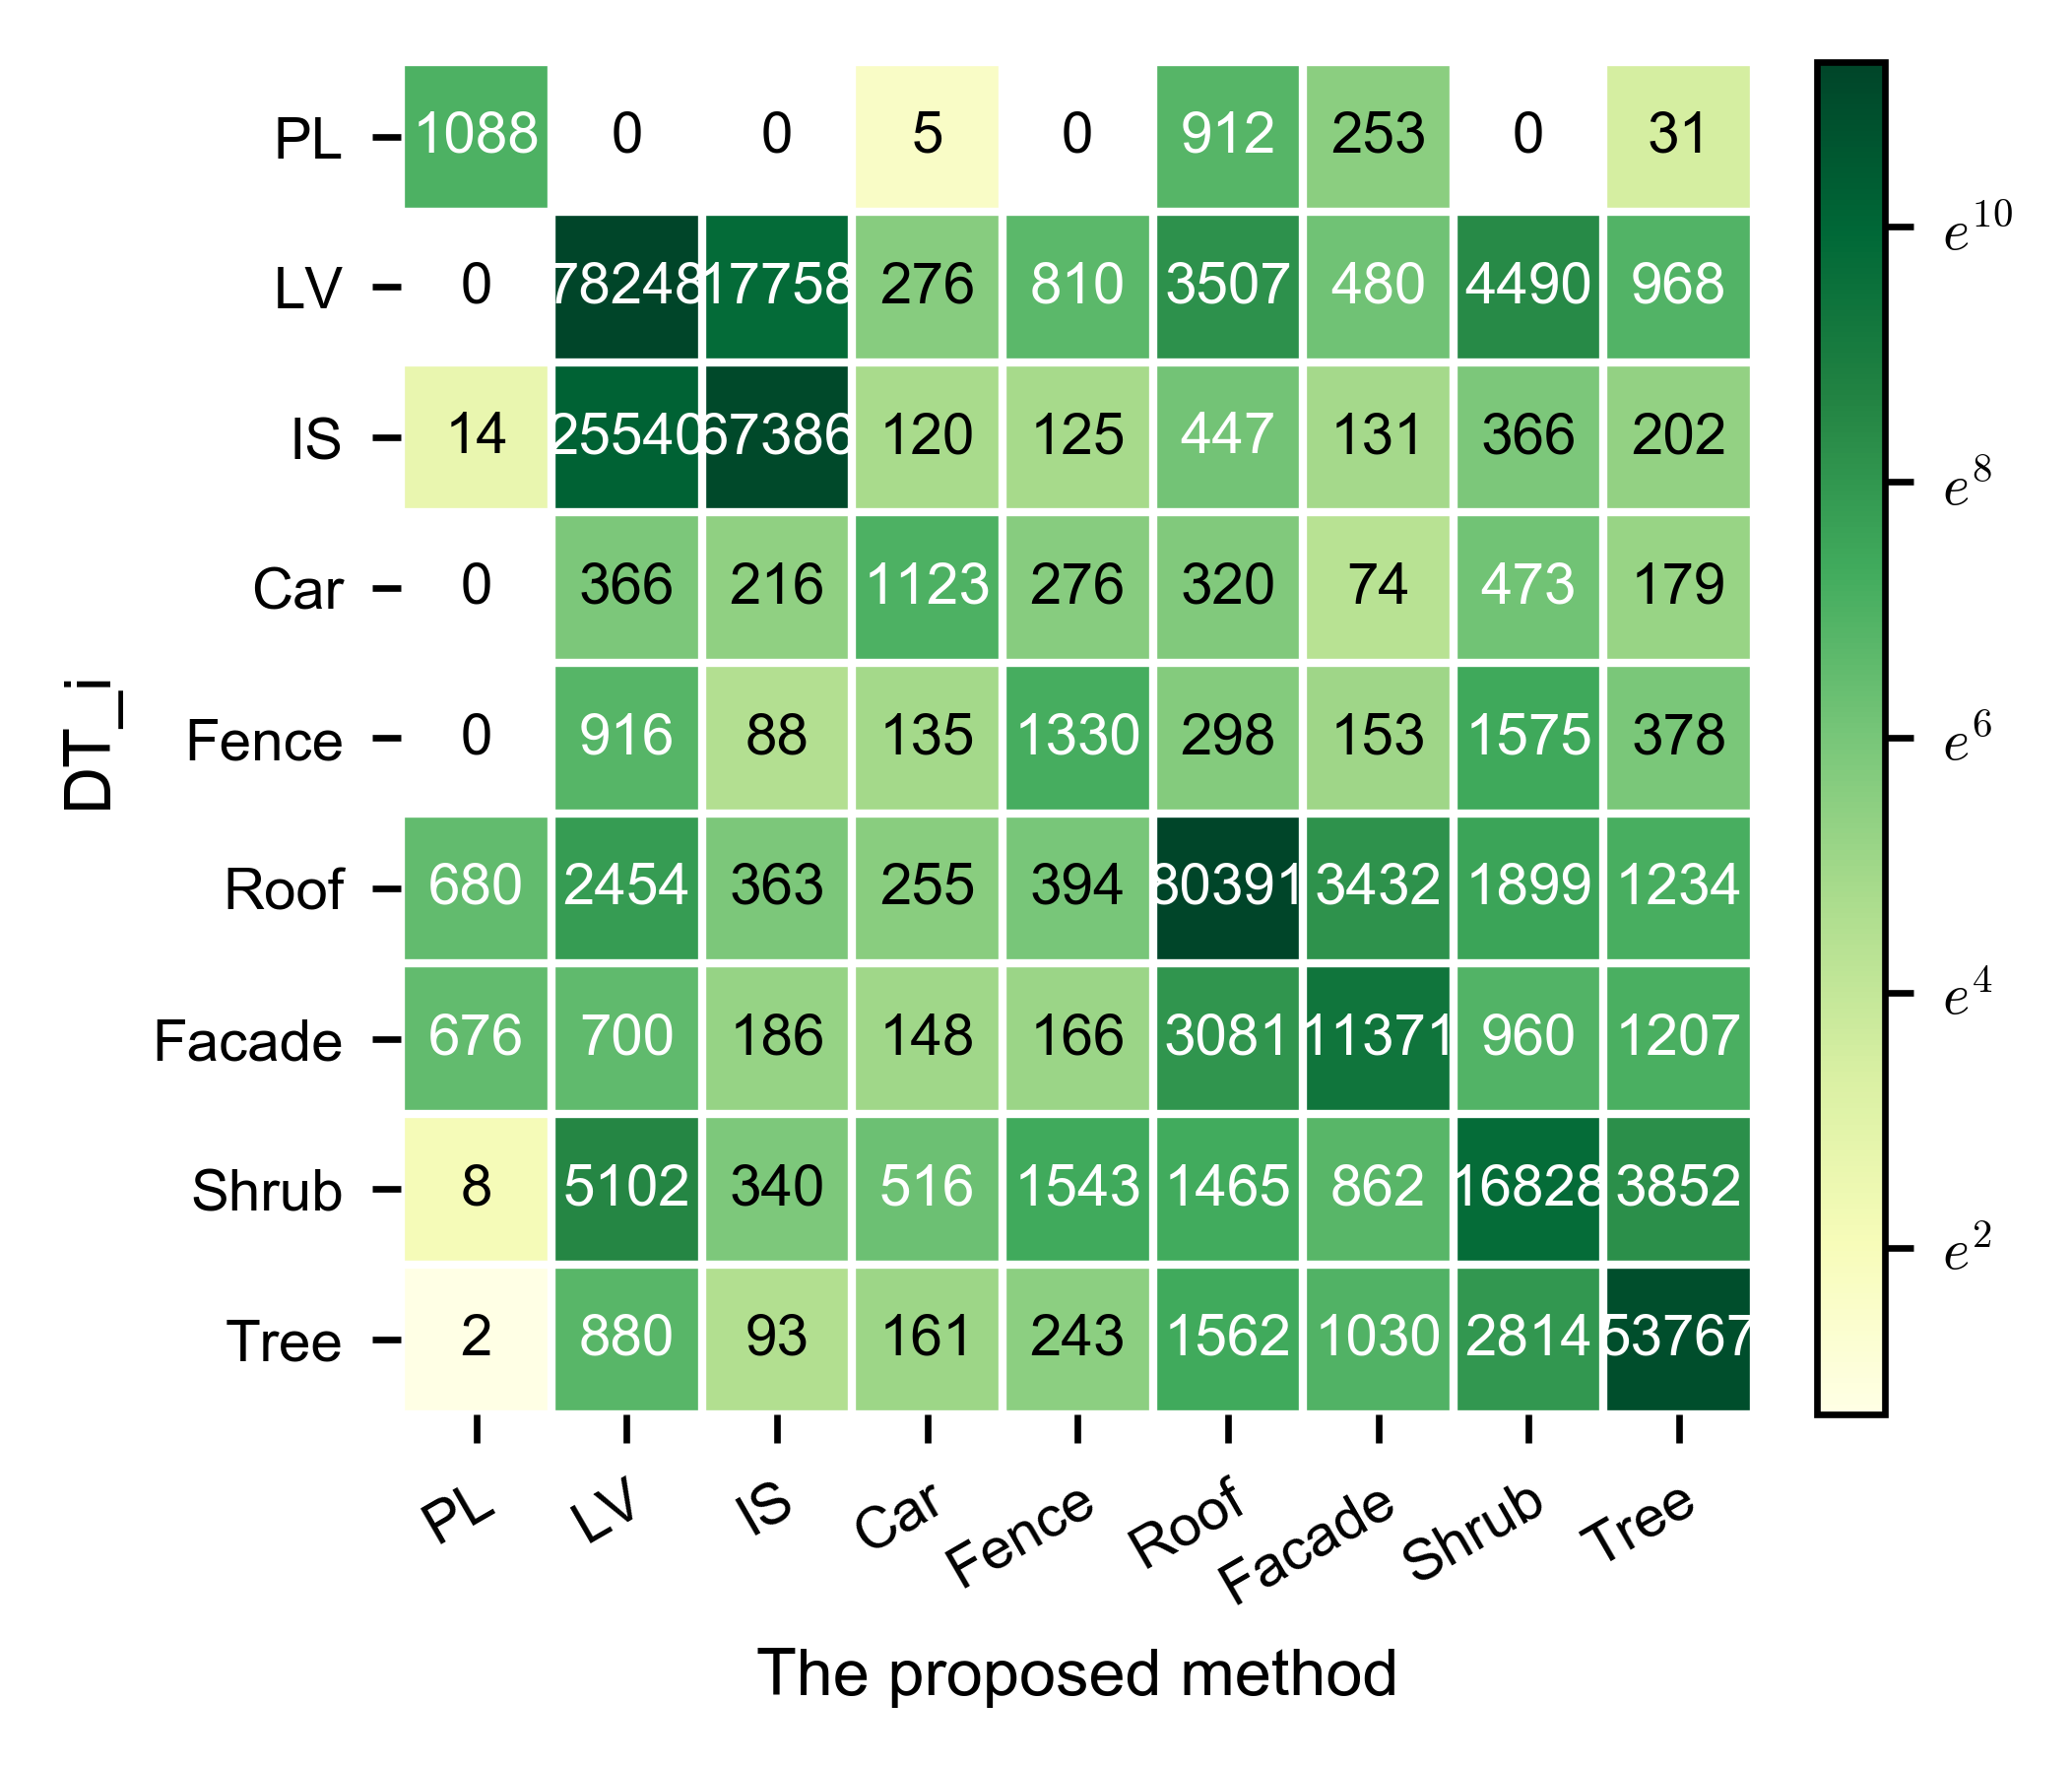

In [34]:
cnf_matrix = confusion_matrix(smooth_DT_with_i, smooth_joint_result)
np.set_printoptions(precision=2)

fig, ax = plt.subplots(figsize=(3.5, 3))
im, cbar = plot_confusion_matrix(cnf_matrix, class_name=class_name, ax=ax,
                   cmap="YlGn")
texts = annotate_confusion(im, valfmt="{x:d}", data=cnf_matrix, fontsize=7)
plt.ylabel('DT_i', fontsize=8)
plt.xlabel('The proposed method', fontsize=8)
plt.tight_layout()
plt.savefig("./result/figure/confusion_matrix_DT_i_proposed.png")

#### simulate the intensity using range function

In [35]:
h = test_data_feature[:, -1]
modify = ((500-h) / (700-h))**2
intensity = test_data[:, -7]
modified_intensity = modify * intensity

In [36]:
# smooth modified intensity using mean within k-neighbourhood
kdt = KDTree(test_xyz, metric = 'euclidean')
ind = kdt.query(test_xyz, k = 6, return_distance=False)
neigh_modified_intensity = modified_intensity[ind]
smooth_modified_intensity = np.average(neigh_modified_intensity, axis=1)
smooth_modified_intensity = smooth_modified_intensity.reshape((-1, 1))
test_data_feature_mi = np.hstack((test_data_feature, smooth_modified_intensity))

#### DT with intensity to handle intensity after modifying

In [37]:
DT_with_mi = clf_DT_i.predict(test_data_feature_mi)
smooth_DT_with_mi = smooth_result(DT_with_mi, ind)

In [38]:
np.set_printoptions(precision=4)
precision_recall_fscore_support(test_data_class, smooth_DT_with_mi)

(array([0.0236, 0.7227, 0.7851, 0.3549, 0.1643, 0.8615, 0.2329, 0.3182,
        0.6969]),
 array([0.0967, 0.6098, 0.8795, 0.37  , 0.0636, 0.7729, 0.3778, 0.3613,
        0.7813]),
 array([0.038 , 0.6615, 0.8296, 0.3623, 0.0917, 0.8148, 0.2881, 0.3384,
        0.7367]),
 array([   600,  98690, 101986,   3708,   7422, 109048,  11224,  24818,
         54226], dtype=int64))

In [39]:
precision_recall_fscore_support(test_data_class, smooth_DT_with_mi, average='weighted')

(0.7193983465772088, 0.7083347501469438, 0.7101172034147317, None)

#### Joint method for handing intensity after modifying

In [40]:
DT_lv_im_mi = smooth_modified_intensity[np.logical_or(DT_without_i == 1, DT_without_i == 2)]
DT_lv_im_mi = DT_lv_im_mi.reshape((-1, 1))
GMM_mi = mixture.GaussianMixture(n_components=2, random_state=0)
GMM_mi.fit(DT_lv_im_mi)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [41]:
proba_GMM_lv_im_mi = GMM_mi.predict_proba(DT_lv_im_mi)

# calculate the ratio of larger and smaller
ratio_proba_GMM_lv_im_mi = np.zeros(proba_GMM_lv_im_mi.shape[0])

proba_GMM_lv_larger_im_mi = proba_GMM_lv_im_mi[:, 1] > proba_GMM_lv_im_mi[:, 0]
ratio_proba_GMM_lv_im_mi[proba_GMM_lv_larger_im_mi] = np.divide(proba_GMM_lv_im_mi[proba_GMM_lv_larger_im_mi, 1],
                                                                proba_GMM_lv_im_mi[proba_GMM_lv_larger_im_mi, 0])

proba_GMM_lv_smaller_im_mi = np.logical_not(proba_GMM_lv_larger_im_mi)
ratio_proba_GMM_lv_im_mi[proba_GMM_lv_smaller_im_mi] = np.divide(proba_GMM_lv_im_mi[proba_GMM_lv_smaller_im_mi, 0],
                                                                 proba_GMM_lv_im_mi[proba_GMM_lv_smaller_im_mi, 1])

In [42]:
DT_lv_im = DT_without_i[np.logical_or(DT_without_i==1, DT_without_i==2)]

# associate cluster with semantic label using knowledge
GMM_lv_im_mi = GMM_mi.predict(DT_lv_im_mi)
GMM_lv_im_mi[GMM_lv_im_mi==0] = 2

In [43]:
a = 1                                                       # a is hyper-parameter, which determine the ratio of GMM and RF, from analysis above, we set a=8
judge = a * ratio_proba_DT_lv_im >= ratio_proba_GMM_lv_im_mi   # compare the probability of RF and GMM, the result is determined by larger
refine_lv_im_mi = np.zeros(judge.shape)
refine_lv_im_mi[judge] = DT_lv_im[judge]
refine_lv_im_mi[np.logical_not(judge)] = GMM_lv_im_mi[np.logical_not(judge)]

joint_result_mi = np.copy(DT_without_i)
joint_result_mi[np.logical_or(joint_result_mi==1, joint_result_mi==2)] = refine_lv_im_mi
smooth_joint_result_mi = smooth_result(joint_result_mi, ind)

In [44]:
precision_recall_fscore_support(test_data_class, smooth_joint_result_mi, average='weighted')

(0.7072054399813229, 0.6803158441861256, 0.6888960647368727, None)

In [45]:
precision_recall_fscore_support(test_data_class, smooth_joint_result_mi)

(array([0.0113, 0.6084, 0.8134, 0.3914, 0.1817, 0.8943, 0.2338, 0.3205,
        0.6874]),
 array([0.0467, 0.704 , 0.6893, 0.2891, 0.1196, 0.7544, 0.3705, 0.3797,
        0.7836]),
 array([0.0183, 0.6527, 0.7462, 0.3326, 0.1443, 0.8184, 0.2867, 0.3476,
        0.7323]),
 array([   600,  98690, 101986,   3708,   7422, 109048,  11224,  24818,
         54226], dtype=int64))